In [ ]:
# %%capture
# !gdown 1CMcTsxSzz6vzvrq_OIwOJFtowI3KHPOa
# !gdown 1JnaVPaqDA60zpT7gkq6VtIPf8nlBGi87
# !unzip Timeline20250531.zip

In [1]:
import os
len(os.listdir('Timeline20250531/cliplets/'))

13046

In [2]:
import pandas as pd
filenames = os.listdir('Timeline20250531/cliplets/')
data = pd.DataFrame({'filename': filenames})
data['letter'] = data.filename.apply(lambda x: x.split('_')[0])
data['TM'] = data.filename.apply(lambda x: int(x.split('_')[1]))
data['number'] = data.filename.apply(lambda x: x.split('_')[2].split('.')[0])
print(data.shape[0])
data.sample(5)
ground_truth_labels = data['letter'].values

13046


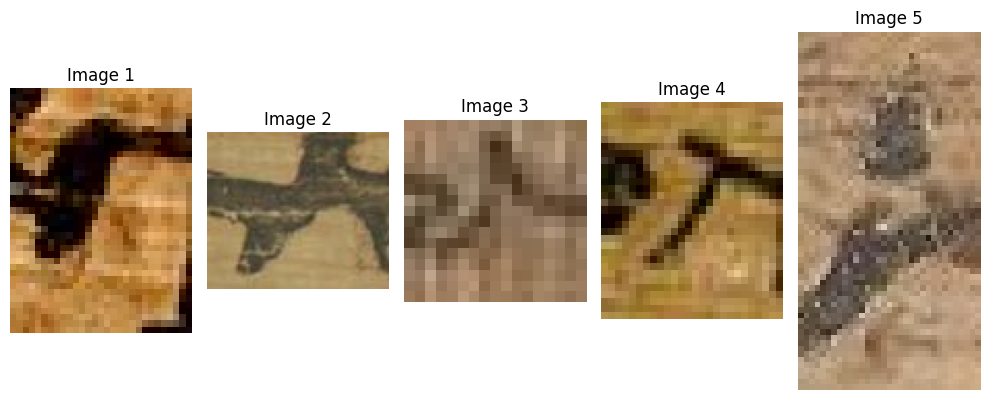

In [3]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

image_folder = 'Timeline20250531/cliplets/'
image_files = [os.path.join(image_folder, f) for f in os.listdir(image_folder) if f.endswith(('.jpg', '.jpeg', '.png'))]

# Display a few images
num_images_to_display = min(5, len(image_files)) # Display up to 5 images

plt.figure(figsize=(10, 5))
for i in range(num_images_to_display):
    img_path = image_files[i]
    img = mpimg.imread(img_path)
    plt.subplot(1, num_images_to_display, i + 1)
    plt.imshow(img)
    plt.title(f'Image {i+1}')
    plt.axis('off')

plt.tight_layout()
plt.show()

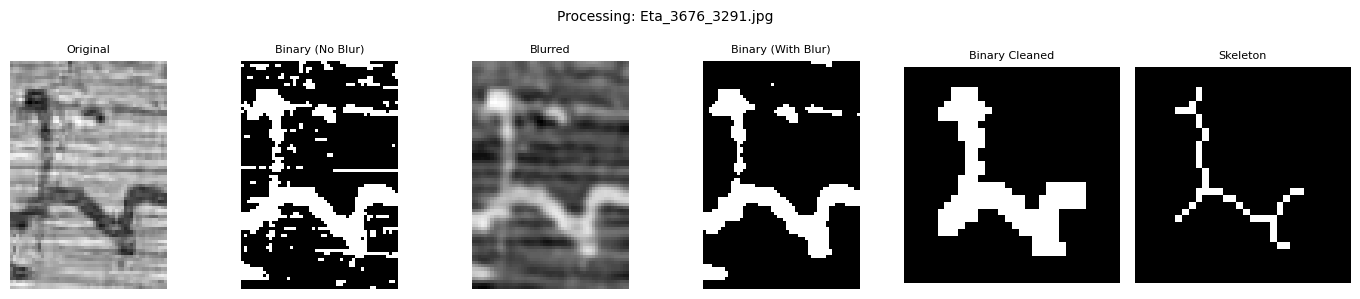

/mnt/efs/fs1/tmp/ipykernel_7641/2456001830.py:46: UserWarning: Only one label was provided to `remove_small_objects`. Did you mean to use a boolean array?
  img_cleaned = remove_small_objects(label(img_bin_bool), min_size=40)


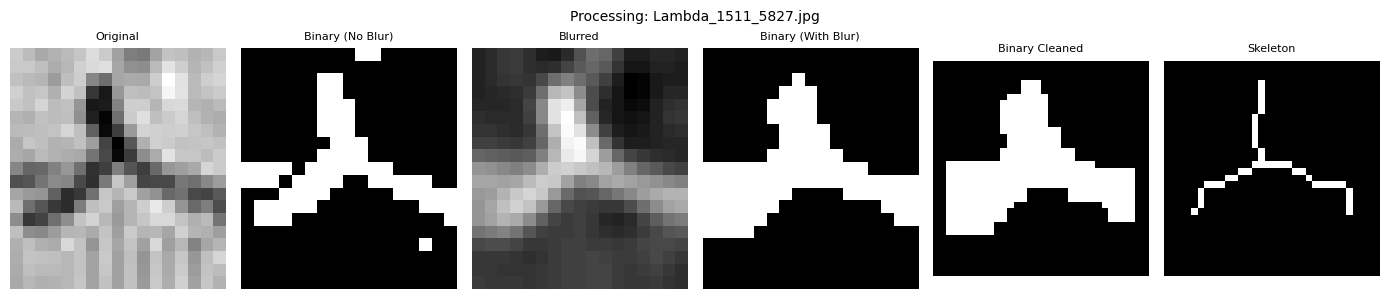

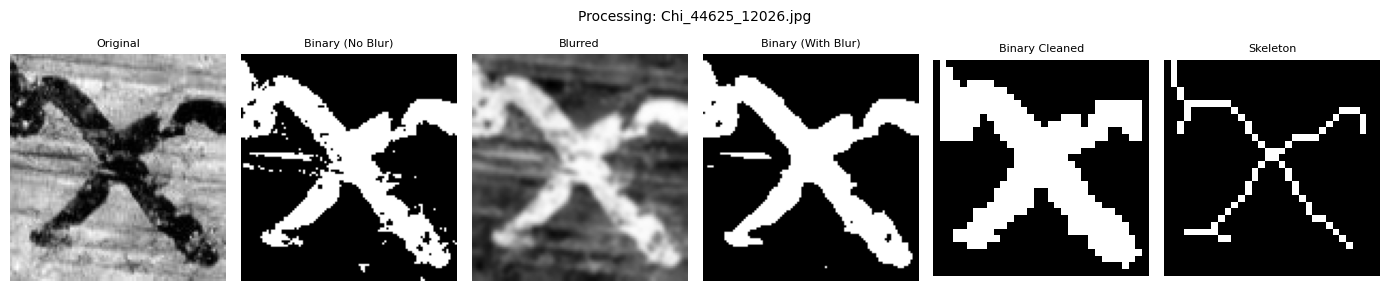

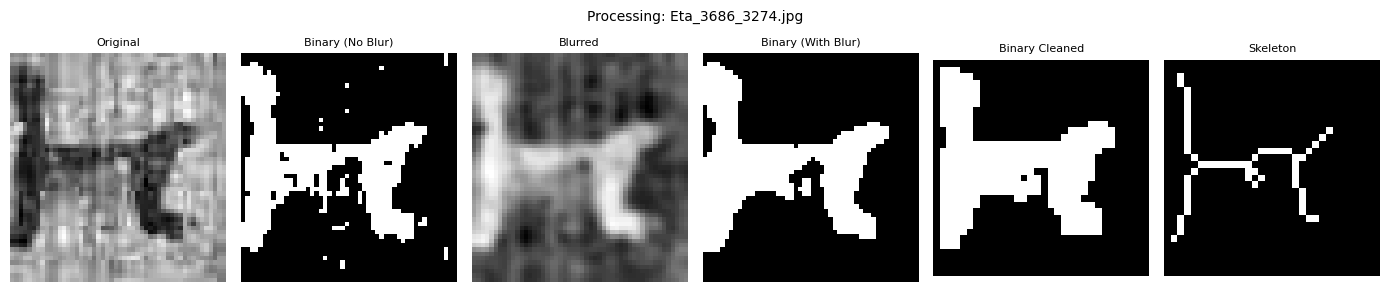

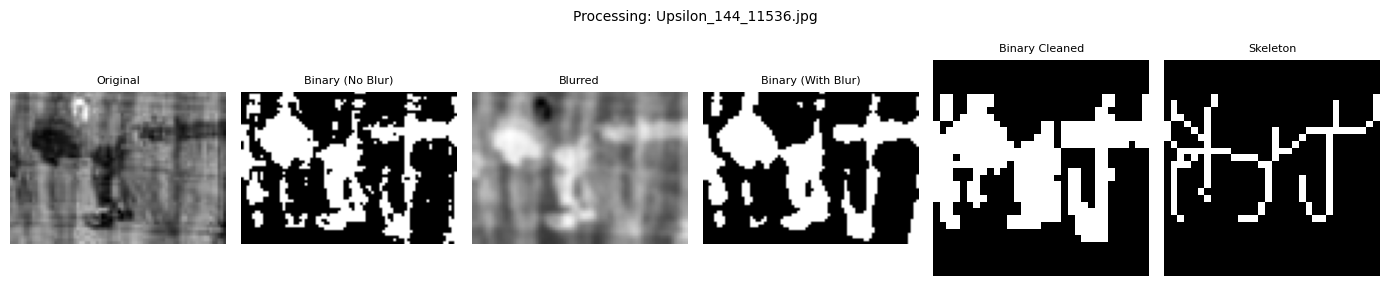

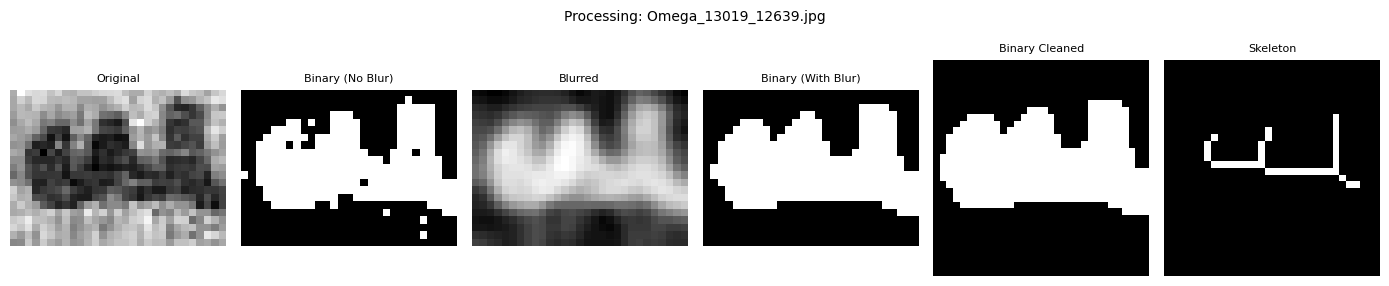

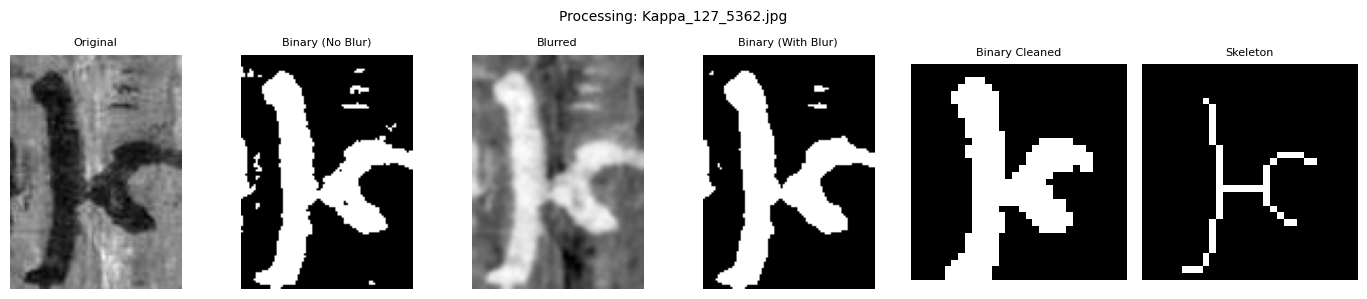

In [4]:
from skimage.morphology import skeletonize
from skimage.util import invert
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.decomposition import PCA
from sklearn.cluster import SpectralClustering
from sklearn.metrics import normalized_mutual_info_score
from sklearn.manifold import TSNE
from skimage.morphology import remove_small_objects
from skimage.measure import label
import warnings
import cv2


def resize_with_aspect_ratio(image, size=(32, 32), padding_value=0):
    h, w = image.shape[:2]
    target_w, target_h = size
    scale = min(target_w / w, target_h / h)
    new_w, new_h = int(w * scale), int(h * scale)
    resized = cv2.resize(image, (new_w, new_h), interpolation=cv2.INTER_AREA)
    result = np.full((target_h, target_w), padding_value, dtype=image.dtype)
    x_offset = (target_w - new_w) // 2
    y_offset = (target_h - new_h) // 2
    result[y_offset:y_offset+new_h, x_offset:x_offset+new_w] = resized
    return result

def preprocess_image_with_debug(image_path, size=(32, 32)):
    img = Image.open(image_path).convert('L')
    img_np = np.array(img)
    # Invert image
    img_inverted = 255 - img_np

    # Without blur
    _, img_bin_noblur = cv2.threshold(img_inverted, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # With blur
    img_blur = cv2.GaussianBlur(img_inverted, (5, 5), 0)
    _, img_bin = cv2.threshold(img_blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    img_resized = resize_with_aspect_ratio(img_bin, size, padding_value=0)
    
    # Remove small objects
    img_bin_bool = img_resized.astype(bool)
    img_cleaned = remove_small_objects(label(img_bin_bool), min_size=40)
    img_bin_cleaned = (img_cleaned > 0).astype(np.uint8) * 255
    
    img_sk = skeletonize(img_bin_cleaned)
    img_normalized = img_sk.astype(np.float32) / 255.0
    
    return {
        'original': img_np,
        'bin_no_blur': img_bin_noblur,
        'blurred': img_blur,
        'binary': img_bin,
        'binary_cleaned': img_bin_cleaned,
        'skeleton': img_sk,
        'final': img_normalized
    }


# Plot multiple images in a cleaner way
for img_path in image_files[100:107]:
    stages = preprocess_image_with_debug(img_path)
    if stages is None:
        continue
    fig, axs = plt.subplots(1, 6, figsize=(14, 3))
    fig.suptitle(f'Processing: {img_path.split("/")[-1]}', fontsize=10)

    axs[0].imshow(stages['original'], cmap='gray')
    axs[0].set_title('Original', fontsize=8)

    axs[1].imshow(stages['bin_no_blur'], cmap='gray')
    axs[1].set_title('Binary (No Blur)', fontsize=8)

    axs[2].imshow(stages['blurred'], cmap='gray')
    axs[2].set_title('Blurred', fontsize=8)

    axs[3].imshow(stages['binary'], cmap='gray')
    axs[3].set_title('Binary (With Blur)', fontsize=8)

    axs[4].imshow((stages['binary_cleaned'] > 0).astype(np.uint8) * 255, cmap='gray')
    axs[4].set_title('Binary Cleaned', fontsize=8)

    axs[5].imshow(stages['skeleton'], cmap='gray')
    axs[5].set_title('Skeleton', fontsize=8)

    for ax in axs:
        ax.axis('off')

    plt.tight_layout()
    plt.show()


In [5]:
def preprocess_image(image_path, size=(32, 32)):
    img = Image.open(image_path).convert('L')
    img_np = np.array(img)
    # Invert image
    img_inverted = 255 - img_np

    # Blur
    img_blur = cv2.GaussianBlur(img_inverted, (5, 5), 0)
    _, img_bin = cv2.threshold(img_blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    img_resized = resize_with_aspect_ratio(img_bin, size, padding_value=0)
    
    # Remove small objects
    img_bin_bool = img_resized.astype(bool)
    img_cleaned = remove_small_objects(label(img_bin_bool), min_size=40)
    img_bin_cleaned = (img_cleaned > 0).astype(np.uint8) * 255
    img_normalized = img_bin_cleaned.astype(np.float32) / 255.0
    return img_normalized.flatten()

image_data = []
labels = []
for i,img_path in enumerate(image_files):
    try:
        processed_img = preprocess_image(img_path)
        if processed_img is not None:
            image_data.append(processed_img)
            labels.append(ground_truth_labels[i])
    except Exception as e:
        print(f"Error processing image {image_data}: {e}")

image_data = np.array(image_data)
labels = np.array(labels)
print(f"Processed {len(image_data)} images with labels.")

/mnt/efs/fs1/tmp/ipykernel_7641/64483438.py:15: UserWarning: Only one label was provided to `remove_small_objects`. Did you mean to use a boolean array?
  img_cleaned = remove_small_objects(label(img_bin_bool), min_size=40)


Processed 13046 images with labels.


In [7]:
known_data = image_data[labels != 'Unknown']
known_labels = labels[labels != 'Unknown']
print(known_data.shape, known_labels.shape)

(13014, 1024) (13014,)


Loaded 13014 images with shape (1024,)
Applying PCA with 10 components...
Clustering PCA features using Spectral Clustering...
NMI Score: 0.3449
Applying PCA with 20 components...
Clustering PCA features using Spectral Clustering...
NMI Score: 0.3970
Applying PCA with 30 components...
Clustering PCA features using Spectral Clustering...
NMI Score: 0.4200
Applying PCA with 40 components...
Clustering PCA features using Spectral Clustering...
NMI Score: 0.4298
Applying PCA with 50 components...
Clustering PCA features using Spectral Clustering...
NMI Score: 0.4321
Applying PCA with 60 components...
Clustering PCA features using Spectral Clustering...
NMI Score: 0.4330
Applying PCA with 70 components...
Clustering PCA features using Spectral Clustering...
NMI Score: 0.4308


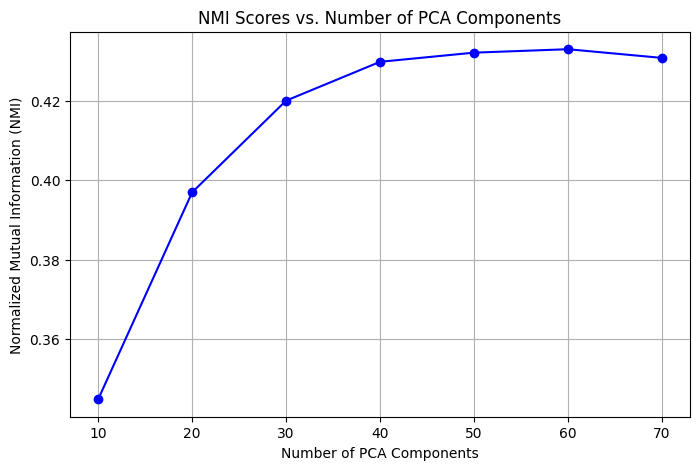

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import SpectralClustering
from sklearn.metrics import normalized_mutual_info_score

# 1. PCA Feature Extraction
def extract_pca_features(X, n_components):
    print(f"Applying PCA with {n_components} components...")
    pca = PCA(n_components=n_components, random_state=42)
    return pca.fit_transform(X)

# 2. Clustering and Evaluation
def cluster_and_evaluate(X_pca, y, n_clusters=24):
    print("Clustering PCA features using Spectral Clustering...")
    spectral = SpectralClustering(n_clusters=n_clusters, affinity='nearest_neighbors', random_state=42)
    cluster_labels = spectral.fit_predict(X_pca)
    nmi = normalized_mutual_info_score(y, cluster_labels)
    print(f"NMI Score: {nmi:.4f}")
    return nmi

# 3. Run PCA and Clustering for multiple component sizes
components_list = [10, 20, 30, 40, 50, 60, 70]
nmi_scores = []

X, y = known_data, np.array(known_labels)
print(f"Loaded {X.shape[0]} images with shape {X.shape[1:]}")

for n_components in components_list:
    X_pca = extract_pca_features(X, n_components)
    nmi = cluster_and_evaluate(X_pca, y)
    nmi_scores.append(nmi)

# 4. Plotting
plt.figure(figsize=(8, 5))
plt.plot(components_list, nmi_scores, marker='o', linestyle='-', color='b')
plt.title("NMI Scores vs. Number of PCA Components")
plt.xlabel("Number of PCA Components")
plt.ylabel("Normalized Mutual Information (NMI)")
plt.grid(True)
plt.show()


Loaded 13014 images with shape (1024,)
Applying PCA to reduce to 60 dimensions...
Performing Spectral Clustering on PCA features...
NMI Score: 0.4330


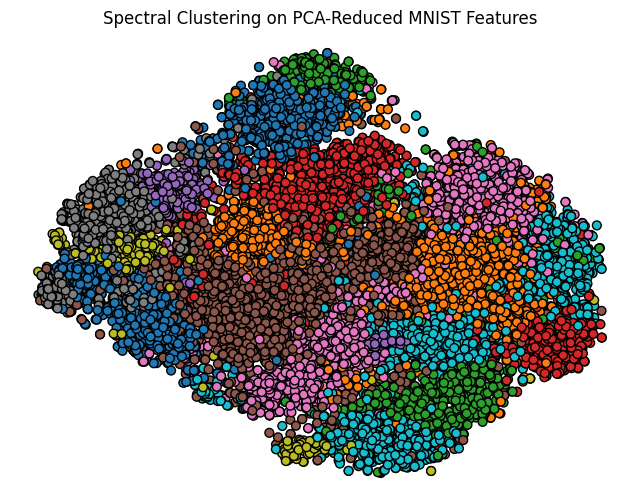

In [9]:
# 2. PCA Feature Extraction
def extract_pca_features(X, n_components=50):
    print(f"Applying PCA to reduce to {n_components} dimensions...")
    pca = PCA(n_components=n_components, random_state=42)
    return pca.fit_transform(X)

# 3. Clustering and Visualization
def cluster_and_visualize(X_pca, y):
    print("Performing Spectral Clustering on PCA features...")
    spectral = SpectralClustering(n_clusters=24, affinity='nearest_neighbors', random_state=42)
    cluster_labels = spectral.fit_predict(X_pca)

    nmi = normalized_mutual_info_score(y, cluster_labels)
    print(f"NMI Score: {nmi:.4f}")

    # t-SNE Visualization
    vis = TSNE(n_components=2, random_state=42).fit_transform(X_pca)
    plt.figure(figsize=(8, 6))
    plt.scatter(vis[:, 0], vis[:, 1], c=cluster_labels, cmap='tab10', s=40, edgecolor='k')
    plt.title("Spectral Clustering on PCA-Reduced MNIST Features")
    plt.axis('off')
    plt.show()
    return cluster_labels

X, y = known_data, np.array(known_labels)
print(f"Loaded {X.shape[0]} images with shape {X.shape[1:]}")
X_pca = extract_pca_features(X, n_components=60)
cluster_labels = cluster_and_visualize(X_pca, y)


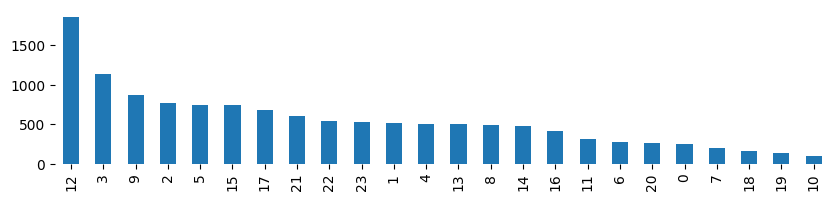

In [13]:
import seaborn as sns

pd.Series(cluster_labels).value_counts().plot.bar(figsize=(10,2));
sns.despine(left=True, bottom=True)

In [27]:
import numpy as np
from collections import Counter

num_clusters = len(set(cluster_labels))

print("Cluster Summary:")
for cluster_id in range(num_clusters):
    # Indices of samples in this cluster
    cluster_indices = np.where(cluster_labels == cluster_id)[0]
    total_images = len(cluster_indices)

    if total_images == 0:
        print(f"Cluster {cluster_id}: Empty")
        continue

    # Get the true labels of those images
    true_labels = y[cluster_indices]

    # Count the occurrences of each label
    label_counts = Counter(true_labels)
    most_common_label, count = label_counts.most_common(1)[0]

    print(f"Cluster {cluster_id}: Total = {total_images} | Most common label = {most_common_label} ({count})")


Cluster Summary:
Cluster 0: Total = 26 | Most common label = Rho (7)
Cluster 1: Total = 675 | Most common label = Omicron (299)
Cluster 2: Total = 995 | Most common label = Pi (427)
Cluster 3: Total = 695 | Most common label = Upsilon (362)
Cluster 4: Total = 1209 | Most common label = Nu (308)
Cluster 5: Total = 657 | Most common label = Omega (438)
Cluster 6: Total = 118 | Most common label = Gamma (103)
Cluster 7: Total = 131 | Most common label = Nu (104)
Cluster 8: Total = 1762 | Most common label = Epsilon (411)
Cluster 9: Total = 906 | Most common label = Iota (392)
Cluster 10: Total = 369 | Most common label = Phi (279)
Cluster 11: Total = 23 | Most common label = Epsilon (4)
Cluster 12: Total = 269 | Most common label = Kappa (35)
Cluster 13: Total = 615 | Most common label = Mu (291)
Cluster 14: Total = 160 | Most common label = Omicron (38)
Cluster 15: Total = 405 | Most common label = Xi (115)
Cluster 16: Total = 300 | Most common label = Tau (225)
Cluster 17: Total = 875 |

Cluster 0 (246 images):


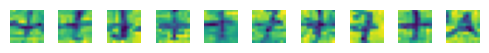

Cluster 1 (520 images):


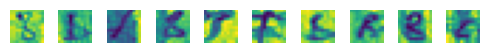

Cluster 2 (766 images):


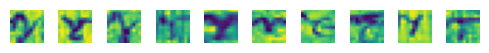

Cluster 3 (1131 images):


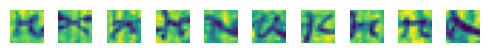

Cluster 4 (499 images):


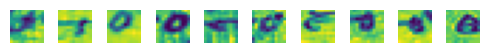

Cluster 5 (745 images):


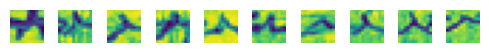

Cluster 6 (268 images):


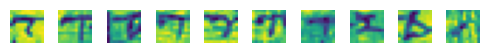

Cluster 7 (191 images):


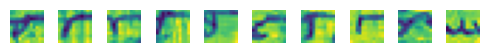

Cluster 8 (494 images):


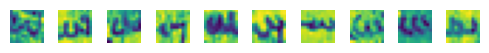

Cluster 9 (863 images):


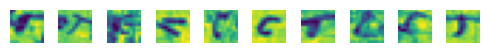

Cluster 10 (96 images):


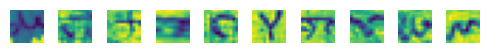

Cluster 11 (314 images):


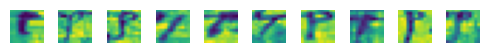

Cluster 12 (1860 images):


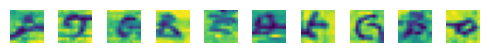

Cluster 13 (495 images):


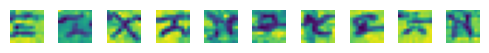

Cluster 14 (479 images):


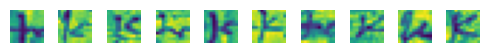

Cluster 15 (741 images):


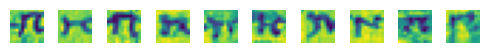

Cluster 16 (418 images):


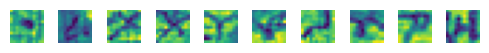

Cluster 17 (682 images):


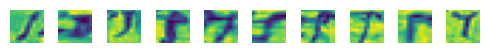

Cluster 18 (155 images):


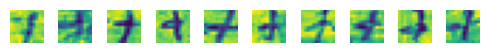

Cluster 19 (129 images):


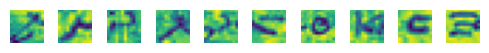

Cluster 20 (254 images):


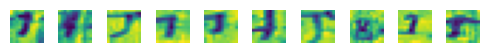

Cluster 21 (602 images):


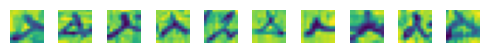

Cluster 22 (538 images):


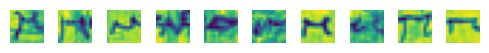

Cluster 23 (528 images):


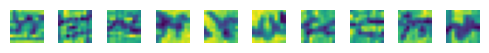

In [14]:
for cluster_id in range(24):
    cluster_indices = np.where(cluster_labels == cluster_id)[0]
    num_images_in_cluster = len(cluster_indices)
    print(f"Cluster {cluster_id} ({num_images_in_cluster} images):")

    images_to_display = cluster_indices[:min(10, num_images_in_cluster)]

    if images_to_display.size > 0:
        plt.figure(figsize=(5, 10))
        for i, img_index in enumerate(images_to_display):
            img_path = image_files[img_index]
            # img = mpimg.imread(img_path)
            img = Image.open(img_path).convert('L').resize((12,12))
            plt.subplot(1, len(images_to_display), i + 1)
            plt.imshow(img)
            plt.axis('off')
        plt.tight_layout()
        plt.show()
    else:
        print("No images in this cluster to display.")

In [15]:
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score

ground_truth_labels = data['letter'].values
nmi = normalized_mutual_info_score(known_labels, cluster_labels)
print(f"Normalized Mutual Information (NMI): {nmi}")
ari = adjusted_rand_score(known_labels, cluster_labels)
print(f"Adjusted Rand Index (ARI): {ari}")

Normalized Mutual Information (NMI): 0.4329809229636847
Adjusted Rand Index (ARI): 0.22746135223394662


In [16]:
from sklearn.metrics import silhouette_score, silhouette_samples
# Compute silhouette scores for each sample
sample_silhouette_values = silhouette_samples(X_pca, cluster_labels)
# Compute the average silhouette score
average_silhouette = silhouette_score(X_pca, cluster_labels)
print(f"Average Silhouette Score (Micro): {average_silhouette}")

Average Silhouette Score (Micro): 0.0157576072961092


In [17]:
cluster_silhouette_scores = []
for i in range(24):
    cluster_indices = np.where(cluster_labels == i)[0]
    if len(cluster_indices) > 1: # Silhouette score is only defined for clusters with more than one point
        cluster_silhouette_scores.append(np.mean(sample_silhouette_values[cluster_indices]).item())
macro_silhouette = np.mean(cluster_silhouette_scores) if cluster_silhouette_scores else 0
print(f"Macro Silhouette Score (Average of Cluster Averages): {macro_silhouette}")
dict(zip(range(24), cluster_silhouette_scores))

Macro Silhouette Score (Average of Cluster Averages): 0.04588100946663568


{0: 0.1367458701133728,
 1: 0.017233818769454956,
 2: -0.007757093291729689,
 3: -0.027778828516602516,
 4: 0.06791633367538452,
 5: 0.015566364862024784,
 6: 0.09739384800195694,
 7: 0.11527609825134277,
 8: 0.09894242137670517,
 9: -0.02431713603436947,
 10: 0.13396722078323364,
 11: 0.09538812190294266,
 12: -0.0638638511300087,
 13: -0.0008842949755489826,
 14: 0.0391874834895134,
 15: 0.01924682781100273,
 16: 0.02059643343091011,
 17: 0.013948904350399971,
 18: 0.07619014382362366,
 19: 0.07822244614362717,
 20: 0.09304226189851761,
 21: 0.010059031657874584,
 22: 0.08761191368103027,
 23: 0.009209887124598026}

In [28]:
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder

def per_class_purity(y_true, y_pred, label_names=None):
    # Encode labels to integers
    le = LabelEncoder()
    y_true_encoded = le.fit_transform(y_true)
    y_pred = np.asarray(y_pred)

    # Build confusion matrix
    cm = confusion_matrix(y_true_encoded, y_pred)
    # Map back to class names
    classes = le.classes_ if label_names is None else label_names

    # Compute purity per true class
    purities = {}
    for i, class_name in enumerate(classes):
        total = np.sum(cm[i, :])
        correct = np.max(cm[i, :])  # cluster with max matches for this class
        purities[class_name] = correct / total if total > 0 else 0.0

    return purities
# Convert string labels to numeric and get cluster labels
le = LabelEncoder()
y_true = le.fit_transform(known_labels)
y_pred = cluster_labels.astype(int)

# Compute per-letter purity
per_letter_purity = per_class_purity(known_labels, cluster_labels)

# Sort by purity descending
sorted_purities = sorted(per_letter_purity.items(), key=lambda x: x[1], reverse=True)

# Print nicely
print("Per-letter Purity Scores (sorted):")
for letter, purity in sorted_purities:
    print(f"Letter '{letter}': {purity:.3f}")

Per-letter Purity Scores (sorted):
Letter 'Theta': 0.738
Letter 'Omega': 0.697
Letter 'Pi': 0.671
Letter 'Phi': 0.669
Letter 'Psi': 0.663
Letter 'Beta': 0.640
Letter 'Delta': 0.618
Letter 'Rho': 0.599
Letter 'Epsilon': 0.597
Letter 'Chi': 0.593
Letter 'Iota': 0.557
Letter 'Upsilon': 0.544
Letter 'Gamma': 0.495
Letter 'Xi': 0.489
Letter 'Zeta': 0.473
Letter 'Mu': 0.462
Letter 'Nu': 0.460
Letter 'Omicron': 0.440
Letter 'Sigma': 0.410
Letter 'Lambda': 0.408
Letter 'Kappa': 0.373
Letter 'Alpha': 0.371
Letter 'Tau': 0.337
Letter 'Eta': 0.321


In [29]:
# 2. PCA Feature Extraction
from sklearn.cluster import KMeans


def extract_pca_features(X, n_components=50):
    print(f"Applying PCA to reduce to {n_components} dimensions...")
    pca = PCA(n_components=n_components, random_state=42)
    return pca.fit_transform(X)

# 3. Clustering and Visualization
def cluster_and_visualize(X_pca, y):
    print("Performing K-Means Clustering on PCA features...")
    kmeans = KMeans(n_clusters=24, random_state=42)
    cluster_labels = kmeans.fit_predict(X_pca)

    nmi = normalized_mutual_info_score(y, cluster_labels)
    print(f"NMI Score: {nmi:.4f}")
    
    return cluster_labels

# Run Full Pipeline
if __name__ == "__main__":
    X, y = known_data, known_labels
    print(f"Loaded {X.shape[0]} images with shape {X.shape[1:]}")
    X_pca = extract_pca_features(X, n_components=200)
    cluster_labels = cluster_and_visualize(X_pca, y)

Loaded 13014 images with shape (1024,)
Applying PCA to reduce to 200 dimensions...
Performing K-Means Clustering on PCA features...
NMI Score: 0.3512


# PCA-Net + Spectral Clustering

In [30]:
from skimage.util import view_as_windows

def extract_patches(images, patch_size):
    all_patches = []
    for img in images:
        # Use view_as_windows to extract all patches of size patch_size x patch_size
        patches = view_as_windows(img, (patch_size, patch_size))
        patches = patches.reshape(-1, patch_size * patch_size)
        all_patches.append(patches)
    return np.vstack(all_patches)

def learn_pca_filters(patches, num_filters):
    pca = PCA(n_components=num_filters)
    pca.fit(patches)
    return pca.components_

def apply_filters(images, filters, patch_size):
    # Convolve each image with each filter
    filtered_maps = []
    for img in images:
        fmap = []
        for f in filters:
            kernel = f.reshape(patch_size, patch_size)
            conv = cv2.filter2D(img, -1, kernel, borderType=cv2.BORDER_REFLECT)
            fmap.append(conv)
        filtered_maps.append(np.array(fmap))
    return filtered_maps  # List of arrays shape: (num_filters, H, W)

def binary_hashing(feature_maps):
    # feature_maps shape: (num_filters, H, W)
    binary_maps = (feature_maps > 0).astype(np.uint8)
    hashed = np.zeros_like(binary_maps[0], dtype=np.uint8)
    for i, bmap in enumerate(binary_maps):
        hashed += (bmap << i)
    return hashed

def block_histogram(hashed_image, block_size, num_bins=256):
    H, W = hashed_image.shape
    hist = []
    for y in range(0, H, block_size):
        for x in range(0, W, block_size):
            block = hashed_image[y:y+block_size, x:x+block_size]
            h, _ = np.histogram(block, bins=num_bins, range=(0, num_bins))
            hist.append(h)
    return np.concatenate(hist)

def pcanet_onestage(images, patch_size=7, num_filters=8, block_size=7):
    # Stage 1: learn filters and apply
    patches = extract_patches(images, patch_size)
    filters = learn_pca_filters(patches, num_filters)
    stage_maps = apply_filters(images, filters, patch_size)

    # Hash + Histogram (on stage 1 outputs)
    features = []
    for fmap in stage_maps:
        hashed = binary_hashing(fmap)
        hist = block_histogram(hashed, block_size)
        features.append(hist)

    return np.array(features)

import numpy as np
from collections import defaultdict


images = [img.reshape(32, 32) for img in known_data]

# Extract PCANet features
features = pcanet_onestage(images,
                         patch_size=11,
                         num_filters=16,
                         block_size=7)

print("PCANet features shape:", features.shape)  # (N, feature_vector_length)

PCANet features shape: (13014, 6400)


Running Spectral Clustering...
Spectral Clustering NMI Score: 0.4122


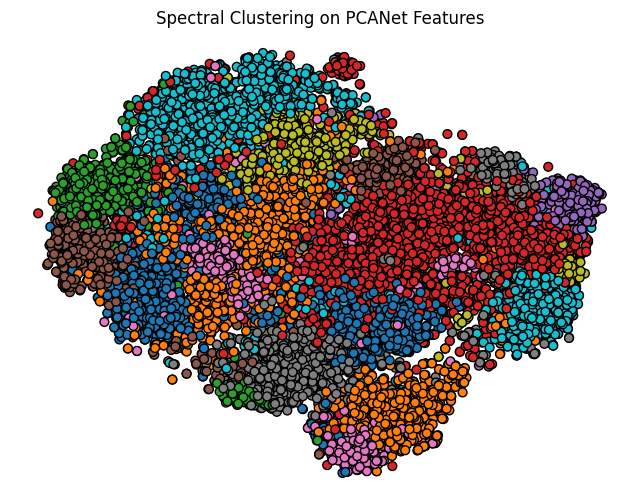

In [31]:
from scipy.signal import convolve2d
from sklearn.cluster import SpectralClustering
from sklearn.preprocessing import normalize
from sklearn.metrics import normalized_mutual_info_score
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import normalized_mutual_info_score
from sklearn.manifold import TSNE
from skimage.util import view_as_windows
from scipy.signal import convolve2d
from sklearn.cluster import SpectralClustering
from sklearn.preprocessing import normalize
import warnings
warnings.filterwarnings("ignore")


# 7. Clustering and Evaluation
def cluster_and_visualize(features, labels):
    # Normalize features (important for spectral clustering)
    features_norm = normalize(features)

    # Spectral Clustering
    spectral = SpectralClustering(n_clusters=24, affinity='nearest_neighbors', random_state=42)
    cluster_labels = spectral.fit_predict(features_norm)

    # Evaluate clustering quality
    nmi = normalized_mutual_info_score(labels, cluster_labels)
    print(f"Spectral Clustering NMI Score: {nmi:.4f}")

    # Visualize with t-SNE
    vis = TSNE(n_components=2, random_state=42).fit_transform(features_norm)
    plt.figure(figsize=(8, 6))
    plt.scatter(vis[:, 0], vis[:, 1], c=cluster_labels, cmap='tab10', s=40, edgecolor='k')
    plt.title("Spectral Clustering on PCANet Features")
    plt.axis('off')
    plt.show()
    return cluster_labels

print("Running Spectral Clustering...")
cluster_labels = cluster_and_visualize(features, known_labels)

In [32]:
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder

def per_class_purity(y_true, y_pred, label_names=None):
    # Encode labels to integers
    le = LabelEncoder()
    y_true_encoded = le.fit_transform(y_true)
    y_pred = np.asarray(y_pred)

    # Build confusion matrix
    cm = confusion_matrix(y_true_encoded, y_pred)
    # cm = cm.T
    # Map back to class names
    classes = le.classes_ if label_names is None else label_names

    # Compute purity per true class
    purities = {}
    for i, class_name in enumerate(classes):
        total = np.sum(cm[i, :])
        correct = np.max(cm[i, :])  # cluster with max matches for this class
        purities[class_name] = correct / total if total > 0 else 0.0

    return purities
# Convert string labels to numeric and get cluster labels
le = LabelEncoder()
y_true = le.fit_transform(known_labels)
y_pred = cluster_labels.astype(int)

# Compute per-letter purity
per_letter_purity = per_class_purity(known_labels, cluster_labels)

# Sort by purity descending
sorted_purities = sorted(per_letter_purity.items(), key=lambda x: x[1], reverse=True)

# Print nicely
print("Per-letter Purity Scores (sorted):")
for letter, purity in sorted_purities:
    print(f"Letter '{letter}': {purity:.3f}")

Per-letter Purity Scores (sorted):
Letter 'Theta': 0.738
Letter 'Omega': 0.697
Letter 'Pi': 0.671
Letter 'Phi': 0.669
Letter 'Psi': 0.663
Letter 'Beta': 0.640
Letter 'Delta': 0.618
Letter 'Rho': 0.599
Letter 'Epsilon': 0.597
Letter 'Chi': 0.593
Letter 'Iota': 0.557
Letter 'Upsilon': 0.544
Letter 'Gamma': 0.495
Letter 'Xi': 0.489
Letter 'Zeta': 0.473
Letter 'Mu': 0.462
Letter 'Nu': 0.460
Letter 'Omicron': 0.440
Letter 'Sigma': 0.410
Letter 'Lambda': 0.408
Letter 'Kappa': 0.373
Letter 'Alpha': 0.371
Letter 'Tau': 0.337
Letter 'Eta': 0.321


In [33]:
from sklearn.metrics import silhouette_score, silhouette_samples
# Compute silhouette scores for each sample
sample_silhouette_values = silhouette_samples(X_pca, cluster_labels)
# Compute the average silhouette score
average_silhouette = silhouette_score(X_pca, cluster_labels)
print(f"Average Silhouette Score (Micro): {average_silhouette}")

Average Silhouette Score (Micro): -0.007719582412391901
